In [16]:
import pandas as pd

In [86]:
train_frame = pd.read_csv('../train.csv')
test_frame = pd.read_csv('../test.csv')

In [87]:
sample_df = train_frame.sample(frac=0.1, random_state=123)
sample_df.shape

(130612, 3)

In [80]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [81]:
stemmer = SnowballStemmer(language='english')

def tokenize(text):
    return [stemmer.stem(token) for token in word_tokenize(text)]

In [82]:
english_stopwords = stopwords.words('english')

In [83]:
vectorizer = TfidfVectorizer(lowercase=True, 
                             tokenizer=tokenize,
                             stop_words=english_stopwords,
                             max_features=1000)

In [88]:
%%time
vectorizer.fit(sample_df.question_text)

/Users/anshujoshi/anaconda3/envs/cancer/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/anshujoshi/anaconda3/envs/cancer/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CPU times: user 14.5 s, sys: 171 ms, total: 14.7 s
Wall time: 14.8 s


TfidfVectorizer(max_features=1000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x28d322d30>)

In [89]:
%%time
inputs = vectorizer.transform(sample_df.question_text)

CPU times: user 14.1 s, sys: 158 ms, total: 14.2 s
Wall time: 14.3 s


In [90]:
targets = sample_df.target.values

In [91]:
from sklearn.model_selection import train_test_split
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs, targets, test_size=0.3, random_state=42)

## Prepare data for training
1. Convert to TF-IDF vectors
2. Convert vectors to PyTorch tensors
3. Create PyTorch dataloaders

### Convert to TF-IDF vectors 

In [92]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

w = tf * log(N/df) <br>
w = frequency of x in doc y <br>
N = total doc <br>
df = total doc where x is present


In [93]:
train_tensors = F.normalize(torch.tensor(train_inputs.toarray()).float(), dim=0)
val_tensors = F.normalize(torch.tensor(val_inputs.toarray()).float(), dim=0)

In [94]:
train_tensors.shape, val_tensors.shape

(torch.Size([91428, 1000]), torch.Size([39184, 1000]))

In [95]:
train_ds = TensorDataset(train_tensors, torch.tensor(train_targets))
val_ds = TensorDataset(val_tensors, torch.tensor(val_targets))

In [96]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)

#### NN network 

In [99]:
from sklearn.metrics import accuracy_score, f1_score

In [112]:
import torch.nn as nn
import torch.nn.functional as F


class classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(1000, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 1)

    def forward(self, inputs):
        out = self.layer1(inputs)
        out = F.relu(out)
        out = self.layer2(out)
        out = F.relu(out)
        out = self.layer3(out)
        out = F.relu(out)
        out = self.layer4(out)
        return out

In [113]:
model = classifier()

In [102]:
for batch in train_dl:
    bi, bt = batch
    # print(bi.shape)
    # print(bt.shape)
    bo = model(bi)
    #convert to prob
    probs = torch.sigmoid(bo)
    #convert to preds

    preds = (probs > 0.5).int()

    break

In [116]:
def evaluate(model, dl):
    losses, accs, f1s = [], [], []
    for batch in dl:
        inputs, targets = batch
        out = model(inputs)
        #convert to probs

        probs = torch.sigmoid(out)[:, 0]
        loss = F.binary_cross_entropy(probs, targets.float(),weight=torch.tensor(20))
        preds = (probs > 0.5).int()
        acc = accuracy_score(targets, preds)
        f1 = f1_score(targets, preds)

        losses.append(loss)
        accs.append(acc)
        f1s.append(f1)

        return torch.mean(torch.tensor(losses)), torch.mean(torch.tensor(accs)), torch.mean(torch.tensor(f1s))



In [106]:
evaluate(model, train_dl)

(tensor(0.7074),
 tensor(0.0703, dtype=torch.float64),
 tensor(0.1314, dtype=torch.float64))

In [121]:
def fit(epochs, lr, model, train_dl, val_dl):
    optimizer = torch.optim.Adam(model.parameters(),lr,weight_decay=1e-5)
    history = [] # for recording epoch-wise results

    #traininig
    for epoch in range(epochs):
        for batch in train_dl:
            input,target = batch
            out = model(input)
            probs = torch.sigmoid(out[:,0])
            
            loss = F.binary_cross_entropy(probs,target.float(),weight=torch.tensor(20))
            
            #opitmization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
    #Evaluation 
    
        result = evaluate(model,val_dl)
        loss,accuracy,f1 = result
        print("epoch {:.4f} , loss {:.4f}, accuracy {:.4f}, f1_score {:.4f}".format(epoch+1,loss,accuracy,f1))
        
        history.append(result)
        
    return history
            

In [130]:
class FeedForwardModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1000, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 1)
        
    def forward(self, xb):
        out = F.relu(self.linear1(xb))
        out = F.relu(self.linear2(out))
        out = F.relu(self.linear3(out))
        out = self.linear4(out)
        return out

In [139]:
%%time
history = []
model = FeedForwardModel()
history += fit(5,0.001,model,train_dl,val_dl)

epoch 1.0000 , loss 2.9923, accuracy 0.9297, f1_score 0.6087
epoch 2.0000 , loss 2.6184, accuracy 0.9219, f1_score 0.4444
epoch 3.0000 , loss 2.4858, accuracy 0.9453, f1_score 0.6957
epoch 4.0000 , loss 2.6632, accuracy 0.9453, f1_score 0.6957
epoch 5.0000 , loss 2.9326, accuracy 0.9375, f1_score 0.6364
CPU times: user 13.5 s, sys: 3.87 s, total: 17.4 s
Wall time: 11.3 s


In [140]:
%%time
history += fit(5,0.0001,model,train_dl,val_dl)


epoch 1.0000 , loss 2.7693, accuracy 0.9375, f1_score 0.6923
epoch 2.0000 , loss 2.8443, accuracy 0.9375, f1_score 0.7143
epoch 3.0000 , loss 2.7768, accuracy 0.9375, f1_score 0.6923
epoch 4.0000 , loss 2.8565, accuracy 0.9375, f1_score 0.6923
epoch 5.0000 , loss 2.8966, accuracy 0.9297, f1_score 0.6400
CPU times: user 13.5 s, sys: 4.03 s, total: 17.5 s
Wall time: 11.4 s


In [149]:
%%time
history += fit(5,0.00001,model,train_dl,val_dl)


epoch 1.0000 , loss 2.9584, accuracy 0.9375, f1_score 0.7143
epoch 2.0000 , loss 2.9603, accuracy 0.9375, f1_score 0.7143
epoch 3.0000 , loss 2.9734, accuracy 0.9375, f1_score 0.7143
epoch 4.0000 , loss 2.9909, accuracy 0.9375, f1_score 0.7143
epoch 5.0000 , loss 2.9760, accuracy 0.9375, f1_score 0.7143
CPU times: user 13.5 s, sys: 4.03 s, total: 17.6 s
Wall time: 11.4 s


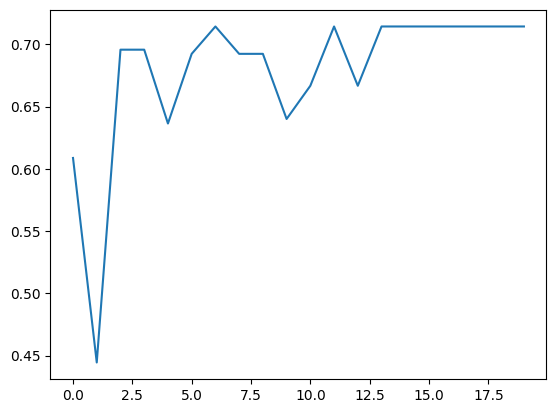

In [150]:
import matplotlib.pyplot as plt
f1s = [item[2] for item in history]
plt.plot(f1s)
plt.show()
